<a href="https://colab.research.google.com/github/Daiyan-Zubaier/Stock-Price-Predictor/blob/main/Stock_Predictor_Daiyan_%26_Rajit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://github.com/jinglescode/time-series-forecasting-pytorch

In [ ]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# To fetch stock market data
!pip install alpha_vantage
from alpha_vantage.timeseries import TimeSeries

print("All libraries loaded")

All libraries loaded


# Configuration Settings
Configures settings for libraries in a 2D hashmap


In [ ]:
config = {
    #Collects stock price data
    "alpha_vantage": {
        "key": "CX2NAREQLV2VVYIV",
        "symbol": "IBM",
        # Or use Compact for last 100 days
        "outputsize": "full",
        "key_adjusted_close": "4. close",
    },
    #Data preprocessing settings
    "data": {
        # number of past days to predict next price
        "window_size": 20,
        # 80% for training, 20% for testing
        "train_split_size": 0.80,
    },
    # Plotting settings
    "plots": {
        # Show data label every x days
        "xticks_interval": 90,
        "color_actual": "#001f3f",
        "color_train": "#3D9970",
        "color_val": "#0074D9",
        "color_pred_train": "#3D9970",
        "color_pred_val": "#0074D9",
        "color_pred_test": "#FF4136",
    },
    # LSTM NN Settings
    "model": {
        # Number of features
        "input_size": 1,
        "num_lstm_layers": 2,
        "lstm_size": 32,
        # Disables neurons
        "dropout": 0.2,
    },
    "training": {
        "device": "cuda",
        "batch_size": 64,
        # Train for x cycles
        "num_epoch": 100,
        "learning_rate": 0.01,
        # Decreasing lr every x epochs
        "scheduler_step_size": 40,
    }
}

Number data points 6363 from 1999-11-01 to 2025-02-18
[ 96.75  94.81  94.37 ... 259.19 261.28 263.07]
[ 96.75  94.81  94.37 ... 259.19 261.28 263.07]
6363
from 1999-11-01 to 2025-02-18


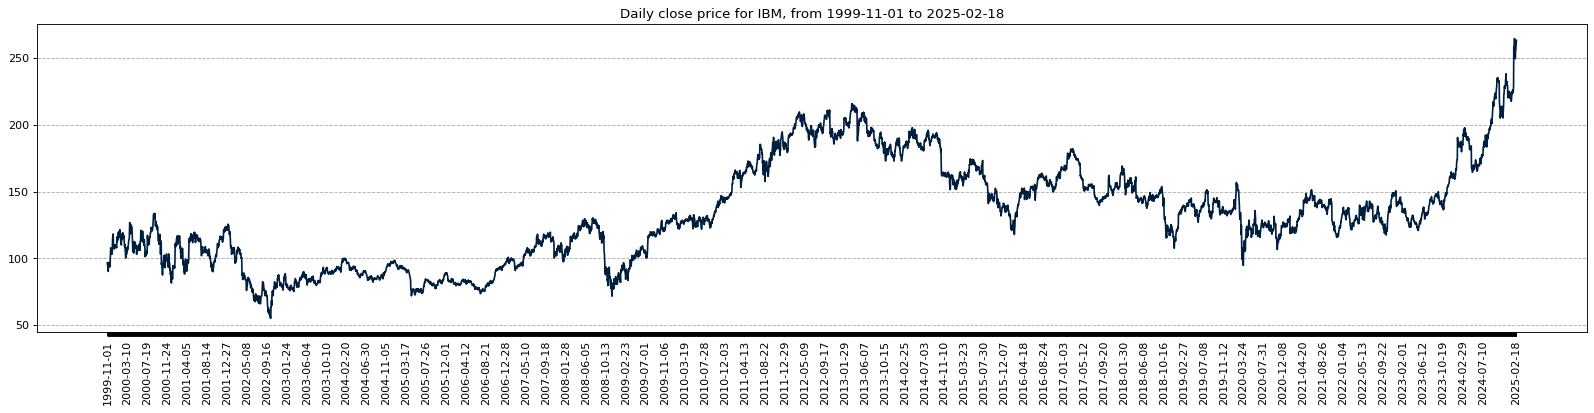

In [ ]:
import requests

def download_data(config):
    url = 'https://www.alphavantage.co/query'
    params = {
        'function': 'TIME_SERIES_DAILY',
        'symbol': config["alpha_vantage"]["symbol"],
        'outputsize': config["alpha_vantage"]["outputsize"],
        'apikey': config["alpha_vantage"]["key"]
    }

    response = requests.get(url, params=params)
    data = response.json()

    if "Error Message" in data:
        raise ValueError(data["Error Message"])

    # Extract data
    data_date = list(data['Time Series (Daily)'].keys())
    data_date.reverse()

    data_close_price = [float(data['Time Series (Daily)'][date]['4. close']) for date in data['Time Series (Daily)'].keys()]
    data_close_price.reverse()
    data_close_price = np.array(data_close_price)

    num_data_points = len(data_date)        # number of available dates.
    display_date_range = "from " + data_date[0] + " to " + data_date[num_data_points - 1]
    print("Number data points", num_data_points, display_date_range)

    return data_date, data_close_price, num_data_points, display_date_range
'''
data_date: List of dates.
data_close_price: NumPy array of closing prices.
num_data_points: Total number of data points.
display_date_range: A string indicating the range of dates.
'''

data_date, data_close_price, num_data_points, display_date_range = download_data(config)
print(data_close_price)
print(data_close_price)
print(num_data_points)
print(display_date_range)

# plot

fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.plot(data_date, data_close_price, color=config["plots"]["color_actual"])
xticks = [data_date[i] if ((i%config["plots"]["xticks_interval"]==0 and (num_data_points-i) > config["plots"]["xticks_interval"]) or i==num_data_points-1) else None for i in range(num_data_points)] # make x ticks nice
x = np.arange(0,len(xticks))
plt.xticks(x, xticks, rotation='vertical')
plt.title("Daily close price for " + config["alpha_vantage"]["symbol"] + ", " + display_date_range)
plt.grid(visible=True, which='major', axis='y', linestyle='--')
plt.show()

In [ ]:
class Normalizer():
    def __init__(self):
        self.mu = None
        self.sd = None

    def fit_transform(self, x):
        self.mu = np.mean(x, axis=(0), keepdims=True)
        self.sd = np.std(x, axis=(0), keepdims=True)
        normalized_x = (x - self.mu)/self.sd
        return normalized_x

    def inverse_transform(self, x):
        return (x*self.sd) + self.mu

# normalize
scaler = Normalizer()
normalized_data_close_price = scaler.fit_transform(data_close_price)

In [ ]:
def prepare_data_x(x, window_size):
    # perform windowing
    n_row = x.shape[0] - window_size + 1
    output = np.lib.stride_tricks.as_strided(x, shape=(n_row, window_size), strides=(x.strides[0], x.strides[0]))
    return output[:-1], output[-1]


def prepare_data_y(x, window_size):
    # # perform simple moving average
    # output = np.convolve(x, np.ones(window_size), 'valid') / window_size

    # use the next day as label
    output = x[window_size:]
    return output

data_x, data_x_unseen = prepare_data_x(normalized_data_close_price, window_size=config["data"]["window_size"])
data_y = prepare_data_y(normalized_data_close_price, window_size=config["data"]["window_size"])

# split dataset

split_index = int(data_y.shape[0]*config["data"]["train_split_size"])
data_x_train = data_x[:split_index]
data_x_val = data_x[split_index:]
data_y_train = data_y[:split_index]
data_y_val = data_y[split_index:]

## Dataloader class

Based on https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
Our class is a map-style dataset

In [ ]:
class StockDataset(Dataset):
    def __init__(self, x, y):
        # expanding dimension of array, currently (batch, window), after (batch, window, features)
        x = np.expand_dims(x, 2)
        self.x = x.astype(np.float32)
        self.y = y.astype(np.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

print("data_x_train", data_x_train.shape)
print("data_x_val", data_x_val.shape)
train_dataset = StockDataset(data_x_train, data_y_train)
val_dataset = StockDataset(data_x_val, data_y_val)

print("Train data shape", train_dataset.x.shape, train_dataset.y.shape)
print("Validation data shape", val_dataset.x.shape, val_dataset.y.shape)

train_dataloader = DataLoader(train_dataset, batch_size=config["training"]["batch_size"], shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=config["training"]["batch_size"], shuffle=True)

data_x_train (5074, 20)
data_x_val (1269, 20)
Train data shape (5074, 20, 1) (5074,)
Validation data shape (1269, 20, 1) (1269,)


In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=32, num_layers=2, output_size=1, dropout=0.2):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.linear_1 = nn.Linear(input_size, hidden_layer_size)  # Projects input shape into hidden layer shape
        self.relu = nn.ReLU()     # Activation function

        # Defining LSTM model
        self.lstm = nn.LSTM(hidden_layer_size, hidden_size=self.hidden_layer_size, num_layers=num_layers, batch_first=True)

        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(num_layers*hidden_layer_size, output_size)  # Outputs back into input shape


    def forward(self, x):
        batchsize = x.shape[0]

        # layer 1
        x = self.linear_1(x)
        x = self.relu(x)

        # LSTM layer
        lstm_out, (h_n, c_n) = self.lstm(x)

        # reshape output from hidden cell into [batch, features] for linear_2
        x = h_n.permute(1, 0, 2).reshape(batchsize, -1)

        # layer 2
        x = self.dropout(x)
        predictions = self.linear_2(x)
        return predictions[:,-1]

def run_epoch(dataloader, is_training=False):
    epoch_loss = 0

    # We don't want to change the NN during validation
    if is_training:
        model.train()
        # Randomly turn off neurons and data normalised
    else:
        model.eval()

    for idx, (x, y) in enumerate(dataloader):

        if is_training:
            # ensures that each batch starts with fresh gradients before backpropagation
            optimizer.zero_grad()

        batchsize = x.shape[0]

        # Move to GPU
        x = x.to(config["training"]["device"])
        y = y.to(config["training"]["device"])

        out = model(x)    # PyTorch automatically calls forward prop
        loss = criterion(out.contiguous(), y.contiguous())    # Mean squared error loss

        if is_training:
            loss.backward()     # Back prop
            optimizer.step()    # Update weights

        epoch_loss += (loss.detach().item() / batchsize)

    lr = scheduler.get_last_lr()[0]

    return epoch_loss, lr

model = LSTMModel(input_size=config["model"]["input_size"], hidden_layer_size=config["model"]["lstm_size"], num_layers=config["model"]["num_lstm_layers"], output_size=1, dropout=config["model"]["dropout"])
model = model.to(config["training"]["device"])

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),
                       lr=config["training"]["learning_rate"],
                       betas=(0.9, 0.98), eps=1e-9)

scheduler = optim.lr_scheduler.StepLR(optimizer,
                                      step_size=config["training"]["scheduler_step_size"],  # learning rate is adjusted (multiplied by gamma)
                                      gamma=0.1)

for epoch in range(config["training"]["num_epoch"]):
    loss_train, lr_train = run_epoch(train_dataloader, is_training=True)
    loss_val, lr_val = run_epoch(val_dataloader)
    scheduler.step()    # Adjust lr

    print('Epoch[{}/{}] | loss train:{:.6f}, test:{:.6f} | lr:{:.6f}'
              .format(epoch+1, config["training"]["num_epoch"], loss_train, loss_val, lr_train))

Epoch[1/100] | loss train:0.072949, test:0.006112 | lr:0.010000
Epoch[2/100] | loss train:0.015177, test:0.004179 | lr:0.010000
Epoch[3/100] | loss train:0.014099, test:0.004595 | lr:0.010000
Epoch[4/100] | loss train:0.012865, test:0.002413 | lr:0.010000
Epoch[5/100] | loss train:0.011137, test:0.003611 | lr:0.010000
Epoch[6/100] | loss train:0.012378, test:0.002278 | lr:0.010000
Epoch[7/100] | loss train:0.011100, test:0.002552 | lr:0.010000
Epoch[8/100] | loss train:0.012464, test:0.002049 | lr:0.010000
Epoch[9/100] | loss train:0.011882, test:0.002581 | lr:0.010000
Epoch[10/100] | loss train:0.011098, test:0.003849 | lr:0.010000
Epoch[11/100] | loss train:0.010097, test:0.002824 | lr:0.010000
Epoch[12/100] | loss train:0.011091, test:0.003072 | lr:0.010000
Epoch[13/100] | loss train:0.011587, test:0.004343 | lr:0.010000
Epoch[14/100] | loss train:0.012332, test:0.004936 | lr:0.010000
Epoch[15/100] | loss train:0.010612, test:0.002488 | lr:0.010000
Epoch[16/100] | loss train:0.01100

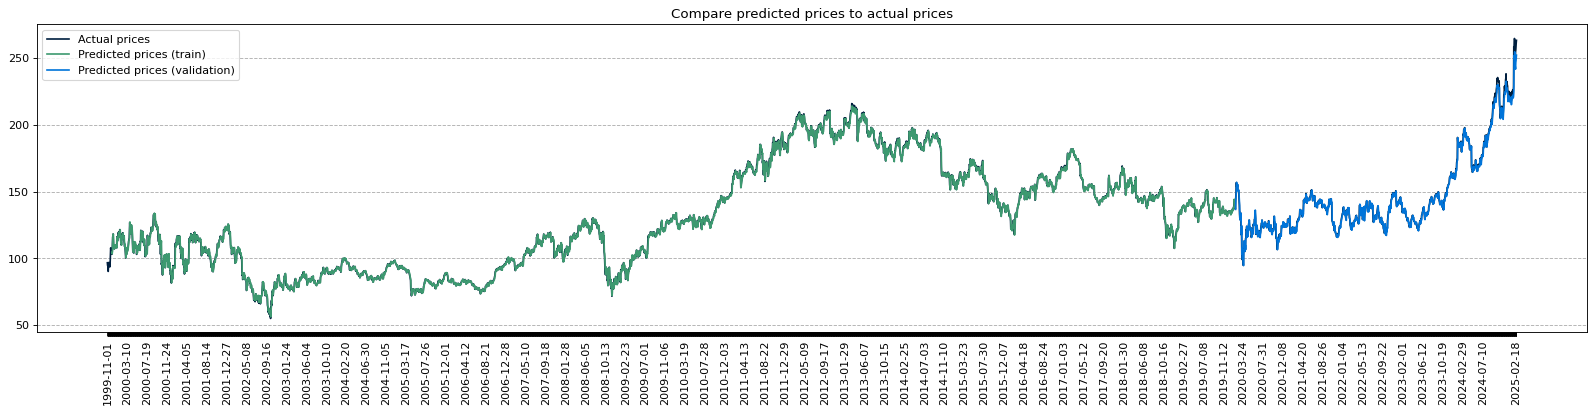

In [ ]:
# re-initialize to ensure, data isnt shuffled when presenting data
train_dataloader = DataLoader(train_dataset, batch_size=config["training"]["batch_size"], shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=config["training"]["batch_size"], shuffle=False)

model.eval()  # Prime for validation and testing

# predict on the training data, to see how well the model managed to learn and memorize
predicted_train = np.array([])

for idx, (x, y) in enumerate(train_dataloader):
    x = x.to(config["training"]["device"])
    out = model(x)
    out = out.cpu().detach().numpy()
    predicted_train = np.concatenate((predicted_train, out))

# predict on the validation data, to see how the model does

predicted_val = np.array([])

for (x, y) in val_dataloader:
    x = x.to(config["training"]["device"])
    out = model(x)                          # Forward prop
    out = out.cpu().detach().numpy()        # Converting output tensor into a numpy array
    predicted_val = np.concatenate((predicted_val, out))

# prepare data for plotting

to_plot_data_y_train_pred = np.zeros(num_data_points)
to_plot_data_y_val_pred = np.zeros(num_data_points)

to_plot_data_y_train_pred[config["data"]["window_size"]:split_index+config["data"]["window_size"]] = scaler.inverse_transform(predicted_train)
to_plot_data_y_val_pred[split_index+config["data"]["window_size"]:] = scaler.inverse_transform(predicted_val)

to_plot_data_y_train_pred = np.where(to_plot_data_y_train_pred == 0, None, to_plot_data_y_train_pred)
to_plot_data_y_val_pred = np.where(to_plot_data_y_val_pred == 0, None, to_plot_data_y_val_pred)

# plots

fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.plot(data_date, data_close_price, label="Actual prices", color=config["plots"]["color_actual"])
plt.plot(data_date, to_plot_data_y_train_pred, label="Predicted prices (train)", color=config["plots"]["color_pred_train"])
plt.plot(data_date, to_plot_data_y_val_pred, label="Predicted prices (validation)", color=config["plots"]["color_pred_val"])
plt.title("Compare predicted prices to actual prices")
xticks = [data_date[i] if ((i%config["plots"]["xticks_interval"]==0 and (num_data_points-i) > config["plots"]["xticks_interval"]) or i==num_data_points-1) else None for i in range(num_data_points)] # make x ticks nice
x = np.arange(0,len(xticks))
plt.xticks(x, xticks, rotation='vertical')
plt.grid(visible=None, which='major', axis='y', linestyle='--')
plt.legend()
plt.show()

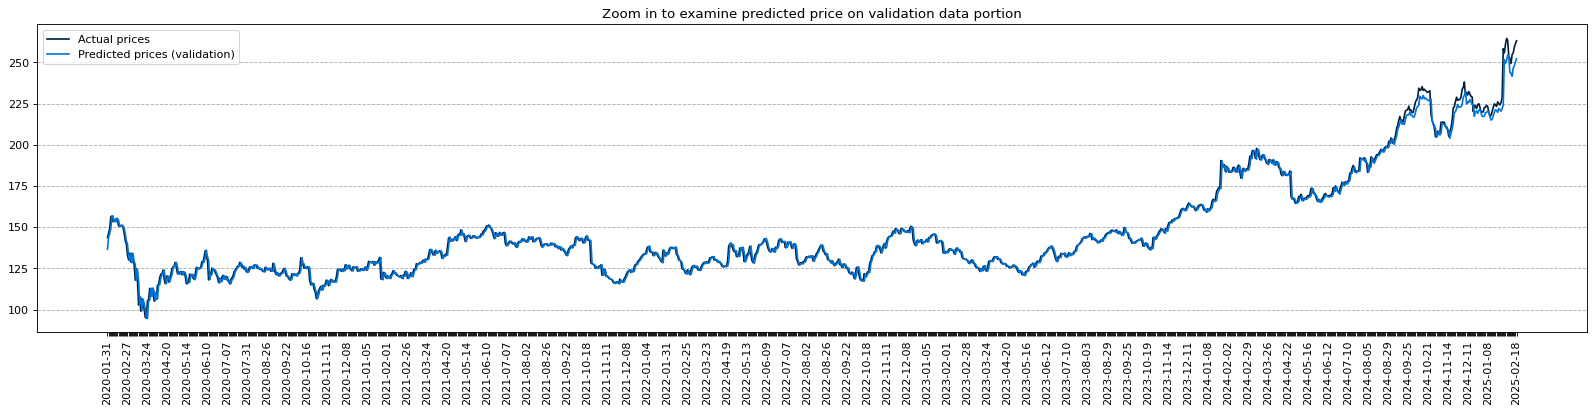

In [ ]:
# prepare data for plotting the zoomed in view of the predicted prices (on validation set) vs. actual prices

to_plot_data_y_val_subset = scaler.inverse_transform(data_y_val)
to_plot_predicted_val = scaler.inverse_transform(predicted_val)
to_plot_data_date = data_date[split_index+config["data"]["window_size"]:]

# plots

fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.plot(to_plot_data_date, to_plot_data_y_val_subset, label="Actual prices", color=config["plots"]["color_actual"])
plt.plot(to_plot_data_date, to_plot_predicted_val, label="Predicted prices (validation)", color=config["plots"]["color_pred_val"])
plt.title("Zoom in to examine predicted price on validation data portion")
xticks = [to_plot_data_date[i] if ((i%int(config["plots"]["xticks_interval"]/5)==0 and (len(to_plot_data_date)-i) > config["plots"]["xticks_interval"]/6) or i==len(to_plot_data_date)-1) else None for i in range(len(to_plot_data_date))] # make x ticks nice
xs = np.arange(0,len(xticks))
plt.xticks(xs, xticks, rotation='vertical')
plt.grid(visible=None, which='major', axis='y', linestyle='--')
plt.legend()
plt.show()

Day 1: 253.3
Day 2: 244.09
Day 3: 235.57
Day 4: 228.64
Day 5: 223.16
Day 6: 219.35
Day 7: 216.76
Day 8: 214.55
Day 9: 212.88
Day 10: 211.53
Day 11: 210.35
Day 12: 209.18
Day 13: 208.11
Day 14: 207.08
Day 15: 206.13
Day 16: 205.19
Day 17: 204.31
Day 18: 203.48
Day 19: 202.73
Day 20: 202.04
Day 21: 201.43
Day 22: 200.88
Day 23: 200.39
Day 24: 199.93
Day 25: 199.51
Day 26: 199.11
Day 27: 198.73
Day 28: 198.37
Day 29: 198.03
Day 30: 197.7
Day 31: 197.38


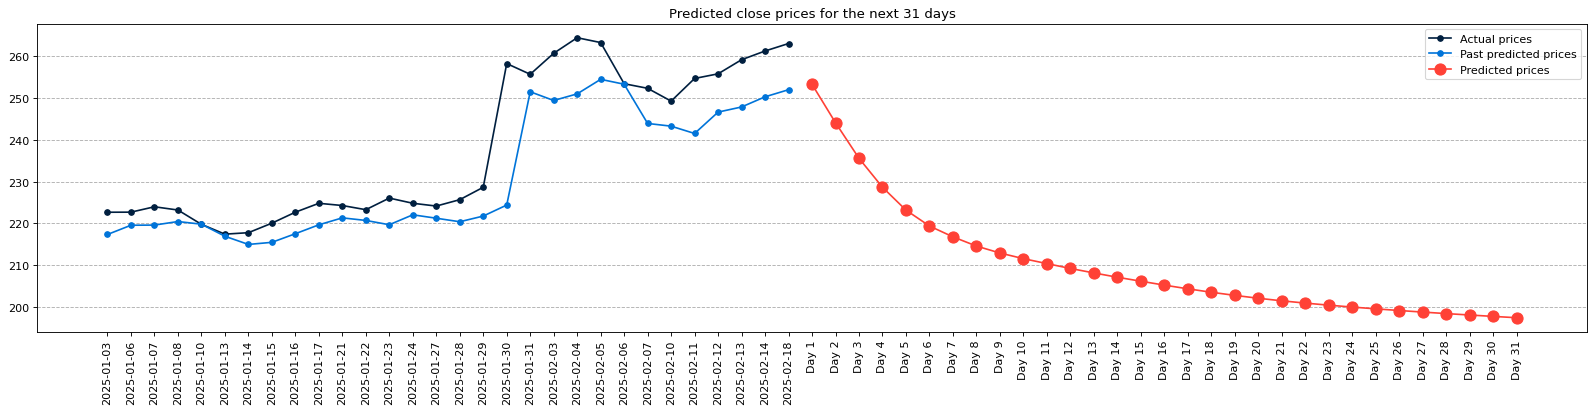

Predicted close prices for the next 31 days:


TypeError: type NoneType doesn't define __round__ method

In [ ]:
# predict the closing price of the next 31 trading days

model.eval()  # Prime for predicting (turn off dropout and normalize data)

predictions = []  # Use a list to collect predictions
current_sequence = data_x_unseen.copy()

forecast_time = 31

for i in range(forecast_time):
    x = torch.tensor(current_sequence).float().to(config["training"]["device"]).unsqueeze(0).unsqueeze(2)  # Prepare input data
    next_price_tensor = model(x)  # Get prediction
    next_price = next_price_tensor.cpu().detach().numpy()[0]  # Convert to numpy
    predictions.append(next_price)  # Append the predicted price to the list
    current_sequence = np.append(current_sequence[1:], next_price)  # Update sequence

# Convert predictions list to a numpy array and inverse transform
predictions = np.array(predictions)  # Convert to numpy array
predicted_prices = scaler.inverse_transform(predictions.reshape(-1, 1))  # Reshape and inverse transform

for i in range(forecast_time):
    print(f"Day {i+1}: {round(predicted_prices[i, 0], 2)}")

# Prepare data for plotting
# Prepare data for plotting
# --------------------------
plot_range = forecast_time  # Forecast for 31 days

# Initialize arrays to hold data for the forecast plot
# Ensure that to_plot_data_y_val has the same length as plot_date_test
to_plot_data_y_val = np.zeros(len(plot_date_test))  # Actual validation prices, extended to cover forecast dates
to_plot_data_y_val_pred = np.zeros(len(plot_date_test)) # Past predicted prices from validation, extended to cover forecast dates
to_plot_data_y_test_pred = np.zeros(len(plot_date_test))  # Our forecasted prices (for all forecast time)

# Fill the relevant parts of the arrays with actual, past predicted, and forecasted values
to_plot_data_y_val[:plot_range-1] = scaler.inverse_transform(data_y_val)[-plot_range+1:]
to_plot_data_y_val_pred[:plot_range-1] = scaler.inverse_transform(predicted_val)[-plot_range+1:]
to_plot_data_y_test_pred[plot_range-1:] = predicted_prices.flatten()  # Assign forecasted prices to the correct indices

# Replace zeros with None so that they are not plotted (this creates gaps where there is no data)
to_plot_data_y_val = np.where(to_plot_data_y_val == 0, None, to_plot_data_y_val)
to_plot_data_y_val_pred = np.where(to_plot_data_y_val_pred == 0, None, to_plot_data_y_val_pred)
to_plot_data_y_test_pred = np.where(to_plot_data_y_test_pred == 0, None, to_plot_data_y_test_pred)


# Prepare the x-axis dates: take the last plot_range-1 dates and append the forecasted dates
plot_date_test = list(data_date[-plot_range+1:])  # Ensure we have a list of dates
forecast_dates = [f"Day {i+1}" for i in range(forecast_time)]  # Label each predicted day as "Day 1", "Day 2", etc.
plot_date_test.extend(forecast_dates)

# --------------------------
# Plot the data
# --------------------------
fig = plt.figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))

plt.plot(plot_date_test, to_plot_data_y_val, label="Actual prices", marker=".", markersize=10, color=config["plots"]["color_actual"])
plt.plot(plot_date_test, to_plot_data_y_val_pred, label="Past predicted prices", marker=".", markersize=10, color=config["plots"]["color_pred_val"])
plt.plot(plot_date_test, to_plot_data_y_test_pred, label="Predicted prices", marker=".", markersize=20, color=config["plots"]["color_pred_test"])

plt.title(f"Predicted close prices for the next {forecast_time} days")
plt.grid(visible=None, which='major', axis='y', linestyle='--')
plt.legend()
plt.xticks(rotation='vertical')
plt.show()

# Print the predicted prices for the next forecast_time days
print(f"Predicted close prices for the next {forecast_time} days:")
for i in range(forecast_time):
    print(f"Day {i+1}: {round(to_plot_data_y_test_pred[i], 2)}")

